# Generating Fractional Cover

## Apply DEA fractional cover endmember/model coefficients to landsat surface reflectance - similar to what is done from DEAfrica [**here**](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Datasets/Fractional_Cover.ipynb)

- [DEA product and algorithm details](https://www.dea.ga.gov.au/products/dea-fractional-cover)

This notebook requires the "FC_Environment", which needs to be installed as in the first cell of this notebook (to be run on commandline). Once done, set the environment in the top-right corner. 


**Notes**
- landsat8_c2l2_sr scaling is not applied as fractional cover algo needs 0-10000 values of surface reflectance (SR)

#### Install the Fractional Cover environment using the following on command line

In [1]:
'''
python3 -m venv ~/venvs/FC_Environment
source ~/venvs/FC_Environment/bin/activate
deactivate
realpath /env/lib/python3.10/site-packages > ~/venvs/FC_Environment/lib/python3.10/site-packages/base_venv.pth
source ~/venvs/FC_Environment/bin/activate
pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc
python -m ipykernel install --user --name=FC_Environment
'''

'\npython3 -m venv ~/venvs/FC_Environment\nsource ~/venvs/FC_Environment/bin/activate\ndeactivate\nrealpath /env/lib/python3.10/site-packages > ~/venvs/FC_Environment/lib/python3.10/site-packages/base_venv.pth\nsource ~/venvs/FC_Environment/bin/activate\npip install --extra-index-url=https://packages.dea.ga.gov.au/ fc\npython -m ipykernel install --user --name=FC_Environment\n'

#### Load packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from itertools import groupby

import warnings
warnings.filterwarnings('ignore')

import datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from datacube.utils.cog import write_cog

from fc.fractional_cover import fractional_cover

from dea_tools.plotting import rgb, display_map
from datacube.drivers.netcdf import write_dataset_to_netcdf

dc = datacube.Datacube(app='Generating_FractionalCover')

#### Set up a dask cluster

In [3]:
from dask_gateway import Gateway

def init_dask_cluster() -> tuple:
    """Connect to an existing or start a new dask gateway cluster.
    Return (cluster, client)
    """
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        cluster = gateway.new_cluster()
    else:
        print(f'An existing cluster was found. Connecting to: {clusters[0].name}')
        cluster=gateway.connect(clusters[0].name)
    cluster.adapt(minimum=1, maximum=4)  # A default starting point
    client = cluster.get_client()

    return (cluster, client)

cluster, client = init_dask_cluster()
display(cluster)

Creating new cluster. Please wait for this to finish.


#### AWS Access

In [4]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

#### display AOI

In [5]:
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

#### Load landsat data

In [6]:
# set time range
time = ('2020-01-01', '2020-12-31')

# Load the data
ds = dc.load(
    product='landsat8_c2l2_sr',
    latitude=latitude,
    longitude=longitude,
    time=time,
    measurements=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
    output_crs="EPSG:32755",
    resolution=(30, -30),
    group_by='solar_day',
    dask_chunks={'time': 1, 'x': 100, 'y': 100}
)

# Rename the data variables to match the fractional cover function's requirements
ds = ds.rename({
    "nir08": "nir",
    "swir16": "swir1",
    "swir22": "swir2",
    "qa_pixel": "fmask",
})

ds = ds.compute()

#### mask cloudy data (no need to scale as is in the correct 0-10000 for fractional cover algo

In [7]:
# Make a mask array for the nodata value
valid_mask = masking.valid_data_mask(ds)

# Make a cloud mask (landsat8_c2l2_sr)
# Multiple flags are combined as logical AND (bitwise)
cloud_mask = masking.make_mask(ds['fmask'], clear='clear')

# Apply each of the masks
filtered_data = ds.where(valid_mask & cloud_mask)

#### run `fractional_cover` algo for each time step

In [8]:
# create ds_fc for each time step and concatenate them along time dimension
ds_fc_list = []
for t in filtered_data.time:
    ds_t = filtered_data.sel(time=t)
    ds_fc_t = fractional_cover(ds_t)
    ds_fc_list.append(ds_fc_t)

ds_fc = xr.concat(ds_fc_list, dim='time').transpose('time', 'y', 'x')
# correct times added back in
ds_fc['time'] = filtered_data.time


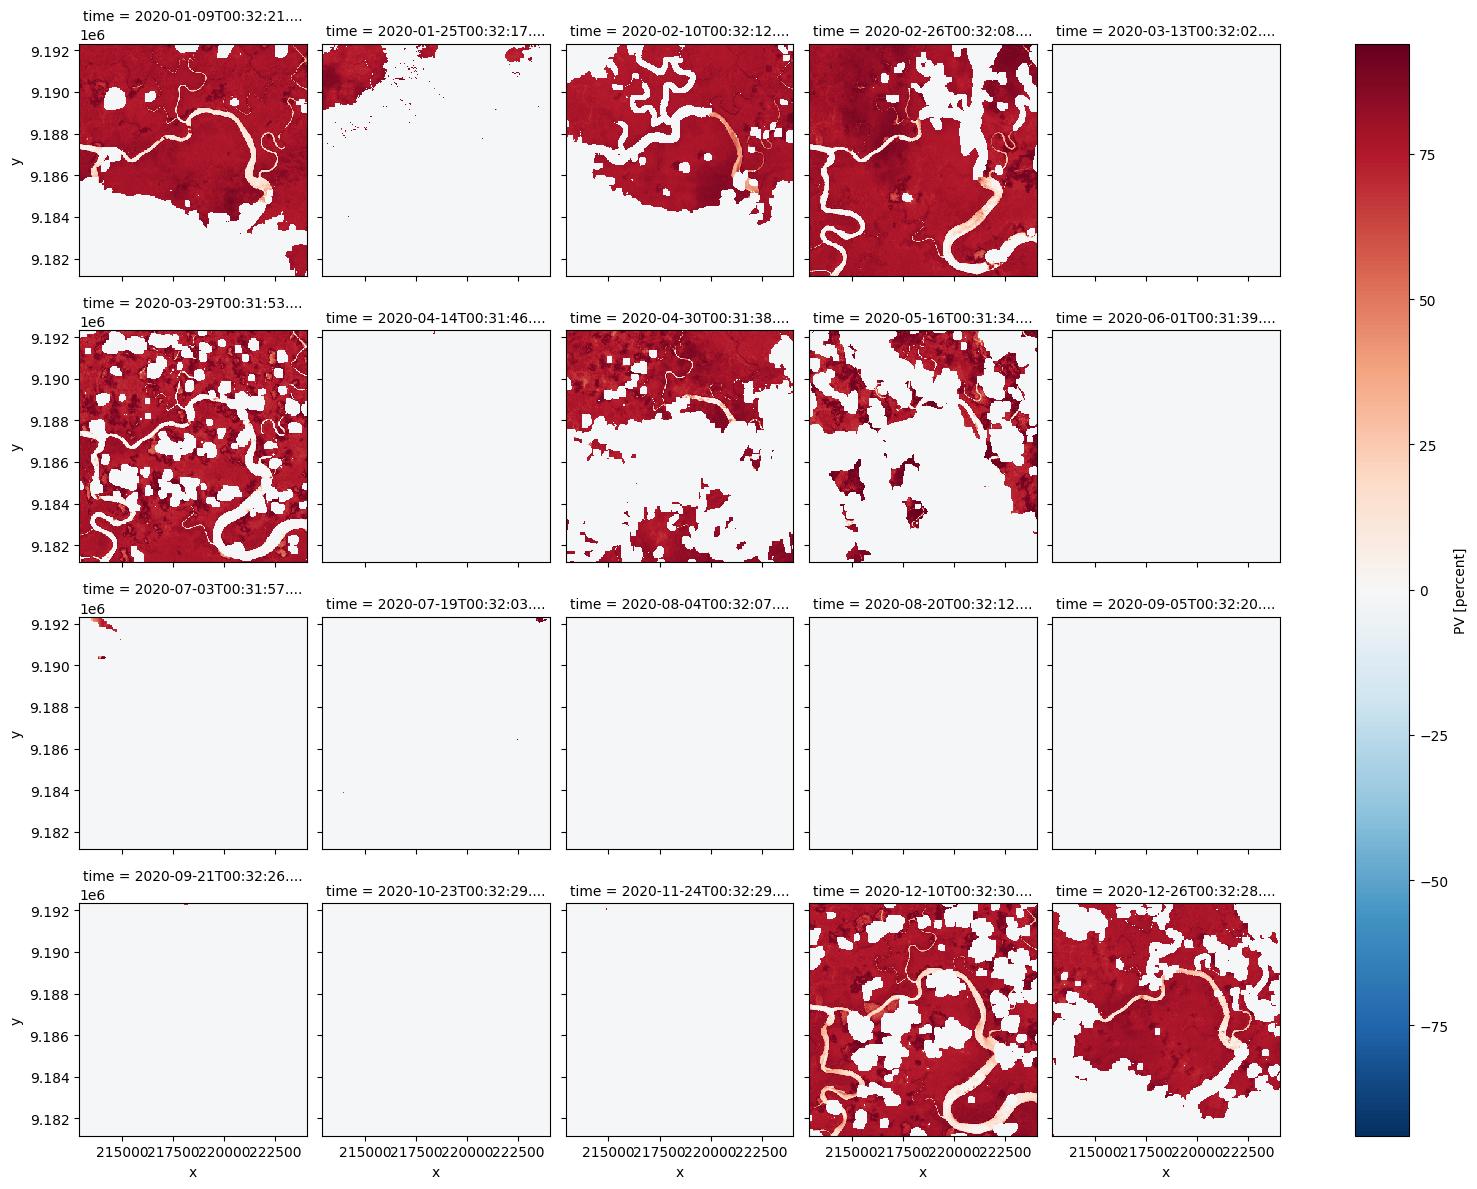

In [9]:
# plotting up to see amount of good available
ds_fc.PV.plot(col="time", col_wrap=5);

In [11]:
# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(ds_fc, '../data/fractionalcover_test.nc')

### make annual percentiles (90th percentile)

In [12]:
# replace negative values with NaN
ds_fc = ds_fc.where(ds_fc >= 0)  

# Resample to annual frequency and skip NaN values
ds_fc_annual = ds_fc.resample(time='A').mean(skipna=True)

# Calculate percentiles
fc_percentile_annual = ds_fc_annual.quantile(q=[0.9], dim='time')

# Convert to percentages and rename variables
# fc_percentile_annual = fc_percentile_annual * 100
fc_percentile_annual = fc_percentile_annual.rename({'PV': 'PV_PC_90',
                                         'NPV': 'NPV_PC_90',
                                         'BS': 'BS_PC_90',
                                         'UE': 'UE_PC_90'})
# remove 'quantile' dim
fc_percentile_annual = fc_percentile_annual.squeeze()

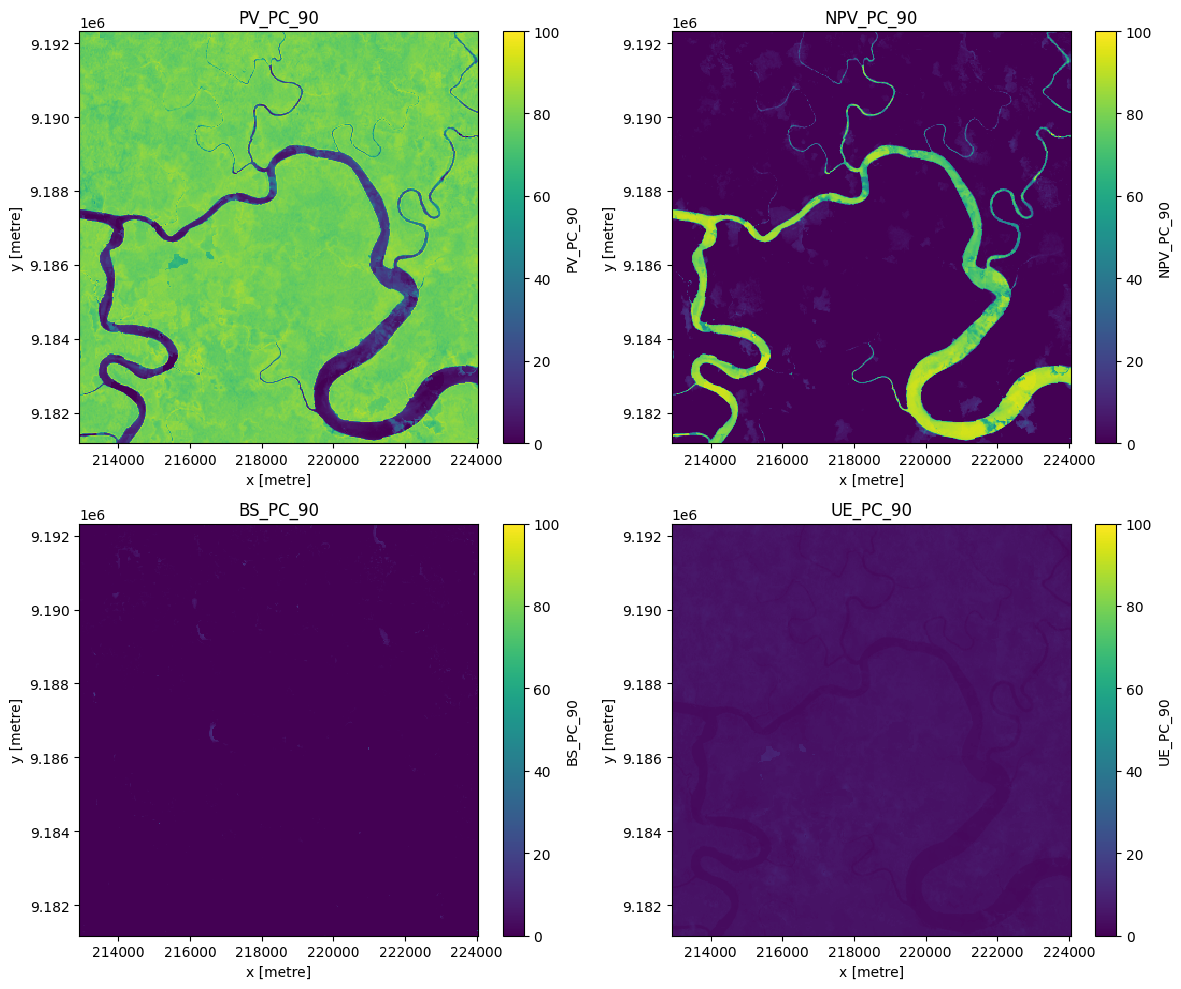

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

fc_percentile_annual['PV_PC_90'].plot(ax=axs[0,0], vmin=0, vmax=100)
axs[0,0].set_title('PV_PC_90')

fc_percentile_annual['NPV_PC_90'].plot(ax=axs[0,1], vmin=0, vmax=100)
axs[0,1].set_title('NPV_PC_90')

fc_percentile_annual['BS_PC_90'].plot(ax=axs[1,0], vmin=0, vmax=100)
axs[1,0].set_title('BS_PC_90')

fc_percentile_annual['UE_PC_90'].plot(ax=axs[1,1], vmin=0, vmax=100)
axs[1,1].set_title('UE_PC_90')

plt.tight_layout()
plt.show()


In [14]:
# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(ds_fc, '../data/fractionalcover_timeseries_test.nc')

### example using similar percentiles for veg/non veg at level 1 - similar to [**here**](https://bitbucket.org/au-eoed/livingearth_lccs_development_tests/src/master/notebooks/level3/le_lccs_dea_level3_tests.ipynb?viewer=nbviewer)


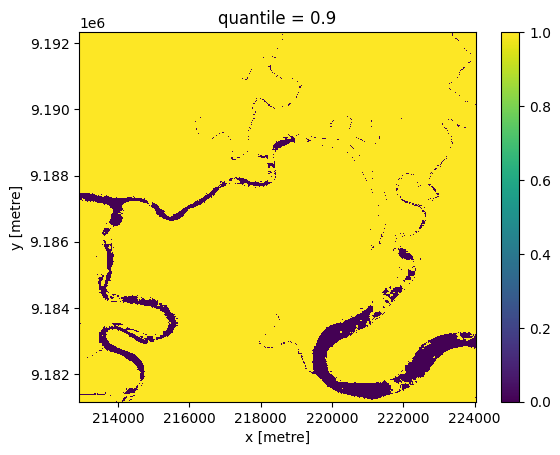

In [15]:
level1 = ((fc_percentile_annual["PV_PC_90"] >= 50) | ((fc_percentile_annual["NPV_PC_90"] >= 50) & (fc_percentile_annual["NPV_PC_90"] <= 80)))
level1.plot()

In [16]:
# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(fc_percentile_annual, '../data/fractionalcover_annual90thpercentile_test.nc')

### example using timeseries for veg/non veg at level 1 - similar to [**here**](https://bitbucket.org/geoscienceaustralia/livingearth_australia/src/master/livingearth_australia/le_plugins/FC_summary.py)
- have taken out the water masking parts as assumes we've calculcated daily wofs (which we could do by combining the `Generating_WOfS.ipynb`)
- output is not wrong, just has issues due to a) need at least an observation every 2 months which we don't really have, b) no water mask

In [15]:
def consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z, y, x]
    :param numpy.array consecutive_numpy: Bool output array for veg (1) and non veg (0)
    :param float required_consecutive: How many consecutive 1's to be classified as veg?
                                       FAO LCCS definition is required_consecutive = 2.
    :param float consec_msk_val: What value to calculcate consecutives on?
                                 Default is veg (1)      
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:, y, x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y, x] = np.nan
                continue            

            # Get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [16]:
    def consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
        '''
        function to get consective count of non veg (0) for each pixel across the time series

        :param numpy.array tv_numpy: 3-D array of tv[z, y, x]
        :param numpy.array consecutive_numpy: Bool output array for veg (1) and non veg (0)
        :param float required_consecutive: How many consecutive 0's to be classified as non veg?
                                           FAO LCCS definition is required_consecutive = 2.
        :param float consec_msk_val: What value to calculcate consecutives on?
                                     Default is non veg (0) 
        '''

        for y in range(tv_numpy.shape[1]):
            for x in range(tv_numpy.shape[2]):
                # If all the values are nan then just set output to nan and carry on
                pixel = tv_numpy[:, y, x]

                if np.all(np.isnan(pixel)):
                    consecutive_numpy[y, x] = np.nan
                    continue
                    
                # Get counts of consecutive non veg classifications (hence label == 0)
                counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 0]

                # Inverse values from consecutive_count_veg to make non veg
                if not counts:
                    consecutive_numpy[y, x] = 1
                elif max(counts) >= required_consecutive:
                    consecutive_numpy[y, x] = 0
                else:
                    consecutive_numpy[y, x] = 1

        return consecutive_numpy

In [17]:
data = ds_fc

data_nan = masking.mask_invalid_data(data)

# # Create water and low-quality fc masks
# no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30)

# Set to null areas with high ue, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop_vars("UE")
del high_ue

# # Where there's water, set pv to 0
# data_nan['pv'] = data_nan.pv.where(no_water, 0)
# data_nan['npv'] = data_nan.npv.where(no_water, 0)

# # Where there's water, set bs to 100
# # this artificial inflation on bs ensures water areas are classified as non-veg
# data_nan['bs'] = data_nan.bs.where(no_water, 100)

# # don't need this anymore
# data_nan = data_nan.drop_vars("water")
# del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where pv > bs
pv_dominant = data_month['PV'] > data_month['BS']
pv_dominant_nan = pv_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where npv > bs
npv_dominant = data_month['NPV'] > data_month['BS']
npv_dominant_nan = npv_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where pv or npv are greater than bs
tv_mask = (pv_dominant_nan + npv_dominant_nan)

# make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For veg - run function to get array of with 1 where number of consecutive values for
# different dates is >= required_consecutive
consecutive_numpy_veg = consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_veg = xr.DataArray(consecutive_numpy_veg, coords=tv_reduce.coords, dims=tv_reduce.dims)

##### non veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For non veg - run function to get array of with 0 where number of consecutive values for
# different dates is >= required_consecutive
consecutive_numpy_nonveg = consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_nonveg = xr.DataArray(consecutive_numpy_nonveg, coords=tv_reduce.coords, dims=tv_reduce.dims)

# Combine veg and non veg masks (to ensure no data is correctly identified)
tv_combine = tv_summary_veg + tv_summary_nonveg

# Make values of 2 == 1 (end result in binary veg mask)
tv_combine_drop = np.where(tv_combine == 2, 1, tv_combine)

# Create new data array with sampe dimensions as original
tv_summary = xr.DataArray(tv_combine_drop, coords=tv_combine.coords, dims=tv_combine.dims)

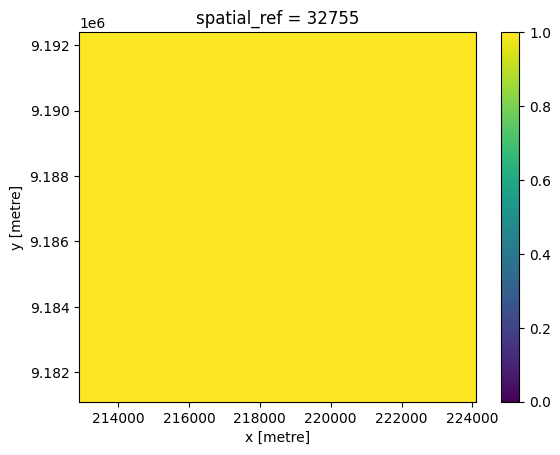

In [18]:
# plot annual total veg (tv)
tv_summary.plot(vmin = 0, vmax = 1)